# Airbnb Price Prediction

## Loading & Preparing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import folium
from folium.plugins import HeatMap


In [2]:
data = pd.read_csv("listings.csv")
data.shape[0]

44684

## Splitting & Preprocessing

#### Seperating Columns

In [3]:
other_features = ["id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", "host_id", "host_url", "host_thumbnail_url", "host_picture_url", 
                  "license", "calendar_updated", "calendar_last_scraped", "host_listings_count", "host_since", "host_location", "neighbourhood", 
                  "first_review", "last_review", "host_neighbourhood", "host_verifications", "neighbourhood_group_cleansed",'review_scores_location']

geo_features = ["latitude", "longitude"]

continuous_features = ["host_acceptance_rate", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", 
                       "review_scores_communication", "review_scores_value", "review_scores_rating", "number_of_reviews", "number_of_reviews_ltm", 
                       "reviews_per_month", "number_of_reviews_l30d", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", 
                       "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "host_total_listings_count", 'host_response_rate',
                       'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm', 'minimum_maximum_nights', 'maximum_nights_avg_ntm', 
                       'maximum_minimum_nights']

continous_features_minmax = ["accommodates", "bathrooms", "beds", "availability_30", "availability_60", "availability_90", "availability_365", 'bedrooms']

multi_categorical_features = ["property_type", "room_type", "has_availability", "instant_bookable", "neighbourhood_cleansed", "host_response_time", "bathrooms_text"]

binary_categorical_features = ['has_availability', 'instant_bookable', 'host_has_profile_pic', 'host_is_superhost', 'host_identity_verified',"host_is_superhost", 
                               "host_has_profile_pic", "host_identity_verified"]

qualitative_features = ["name", "description", "neighborhood_overview", "host_name", "host_about"]

target = "price"

#### Converting Columns to Appriopriate Data Type

In [4]:
continuous_features_other = ["host_acceptance_rate", "host_response_rate"]

for column in continuous_features_other:
    data[column] = data[column].astype(str).str.replace('%', '', regex=False).astype(float) / 100

for column in continuous_features:
    data[column] = data[column].astype(str).str.replace('%', '', regex=False).astype(float)

data['price'] = data['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

data[qualitative_features] = data[qualitative_features].astype(str)

#### Encoding Amenities

In [5]:
# data['amenities'] = data['amenities'].str.replace(r'[^\w\s,]', '', regex=True)
# data['amenities'] = data['amenities'].str.split(',').apply(lambda x: [item.strip() for item in x if item.strip()])
# data['amenities'] = data['amenities'].apply(lambda x: ','.join(x))
# amenity_dummies = data['amenities'].str.get_dummies(sep=',').rename(lambda x: x.strip(), axis=1)
# amenity_dummies = amenity_dummies.sum().sort_values(ascending=False).head(20).idex
# print(amenity_dummies.column)
# data = pd.concat([data, amenity_dummies], axis = 1).drop(columns=['amenities_str'])
# binary_categorical_features += list(amenity_dummies.columns)

#### Check Host Has Supplied Information

In [6]:
data['description'] = data['description'].replace(np.nan, "")
data['description_count'] = [1 if i != "" else 0 for i in data['description']]

#### Dropping non relevant features

In [7]:
data = data.drop(columns=other_features)

#### Splitting to Training, Validation & Testing

In [8]:
# Set a random seed for reproducibility
np.random.seed(42)

# Assuming 'data' is your DataFrame and 'target' is 'review_scores_rating'

# 1. Perform KMeans clustering on 'latitude' and 'longitude'
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['latitude', 'longitude']])

# 2. Get unique clusters
clusters = data['cluster'].unique()

# 3. Randomly select two clusters for validation and testing (ensure they are different)
selected_clusters = np.random.choice(clusters, size=2, replace=False)
cluster_for_test, cluster_for_val = selected_clusters

# 4. Create the test and validation datasets based on the selected clusters
test_data = data[data['cluster'] == cluster_for_test]
val_data = data[data['cluster'] == cluster_for_val]

# 5. Use the remaining data for training
train_data = data[~data['cluster'].isin(selected_clusters)]

# 6. Define your features (X) and target (y) for each set
X_train = train_data.drop(columns=[target, 'cluster'])  # Replace 'review_scores_rating' if your target variable has a different name
y_train = train_data[target]

X_val = val_data.drop(columns=[target, 'cluster'])
y_val = val_data[target]

X_test = test_data.drop(columns=[target, 'cluster'])
y_test = test_data[target]

# 7. Output the shapes of each dataset to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\mdall\anaconda3\envs\DATA1030\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mdall\anaconda3\envs\DATA1030\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\mdall\anaconda3\envs\DATA1030\Lib\subprocess.py",

Training set shape: (38670, 52) (38670,)
Validation set shape: (774, 52) (774,)
Test set shape: (5240, 52) (5240,)


#### Imputing and Scaling Data

In [9]:
class TfidfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10):
        self.max_features = max_features
        self.vectorizers = {}

    def fit(self, X, y=None):
        for feature in X.columns:
            vectorizer = TfidfVectorizer(max_features=self.max_features, stop_words='english')
            vectorizer.fit(X[feature].astype(str))
            self.vectorizers[feature] = vectorizer
        return self

    def transform(self, X):
        tfidf_features = []
        for feature, vectorizer in self.vectorizers.items():
            tfidf_transformed = vectorizer.transform(X[feature].astype(str)).toarray()
            tfidf_df = pd.DataFrame(tfidf_transformed, columns=[f"{feature}_tfidf_{i}" for i in range(tfidf_transformed.shape[1])])
            tfidf_features.append(tfidf_df)
        return pd.concat(tfidf_features, axis=1)

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ('continuous', Pipeline(steps=[('scaler', StandardScaler())]), continuous_features),
    ('nominal', Pipeline(steps=[('scaler', MinMaxScaler())]), continous_features_minmax),
    ('categorical', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ]), binary_categorical_features + multi_categorical_features),
    ('tfidf', TfidfTransformer(max_features=10), qualitative_features)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)

print(X_train.shape[0])
print(X_train.shape[1])

38670
473


#### Converting Data Back to DataFrame

In [11]:
def get_column_names(preprocessor, X):
    output_feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'continuous' or name == 'nominal':
            # Continuous or nominal features: no change in feature names
            output_feature_names.extend(columns)
            
        elif name == 'categorical':
            # OneHotEncoder: get the feature names
            encoder = transformer.named_steps['encoder']
            ohe_feature_names = encoder.get_feature_names_out(columns)
            output_feature_names.extend(ohe_feature_names)
        
        elif name == 'tfidf':
            # Custom TfidfTransformer: construct the feature names manually
            for col in columns:
                output_feature_names.extend([f"{col}_tfidf_{i}" for i in range(transformer.max_features)])

    return output_feature_names

In [12]:
# 6. Get all feature names after transformation
transformed_columns = get_column_names(preprocessor, X_train)

# 8. Create a DataFrame with transformed data and new feature names
X_train = pd.DataFrame(X_train, columns=transformed_columns)

# 9. Display the shape and the DataFrame with feature names
print(X_train.shape)

(38670, 473)


## EDA

#### General Dataset

In [13]:
total_missing_rows = data[data.isnull().any(axis=1)].shape[0]

print(total_missing_rows)

20117


In [14]:
num_rows = data.shape[0]
num_columns = data.shape[1]
column_names = data.columns.tolist()
missing_values = data.isnull().sum()
missing_percentage = (missing_values / num_rows) * 100

# Data dimensions
print('Data dimensions:', data.shape)

# Fraction of missing values per feature
perc_missing_per_ftr = data.isnull().sum(axis=0) / data.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Data types of the features with missing values
print('Data types of the features with missing values:')
print(data[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

# Fraction of points (rows) with missing values
frac_missing = sum(data.isnull().sum(axis=1) != 0) / data.shape[0]
print('Fraction of points with missing values:', frac_missing)

Data dimensions: (44684, 54)
Fraction of missing values in features:
host_response_time             0.218490
host_response_rate             0.218490
host_acceptance_rate           0.208218
host_is_superhost              0.006490
host_total_listings_count      0.000045
host_has_profile_pic           0.000045
host_identity_verified         0.000045
bathrooms                      0.182280
bathrooms_text                 0.000604
bedrooms                       0.062058
beds                           0.185256
price                          0.182258
has_availability               0.072822
review_scores_rating           0.271104
review_scores_accuracy         0.272021
review_scores_cleanliness      0.272021
review_scores_checkin          0.272223
review_scores_communication    0.272066
review_scores_value            0.272267
reviews_per_month              0.271104
dtype: float64
Data types of the features with missing values:
host_response_time              object
host_response_rate           

In [15]:
x_train_shape = X_train.shape

missing_rows_count = X_train.isnull().any(axis=1).sum()

print(f"Shape of X_train: {x_train_shape}")
print(f"Number of rows with missing values in X_train: {missing_rows_count}")


Shape of X_train: (38670, 473)
Number of rows with missing values in X_train: 17641


#### Target

In [16]:
print(data[target].describe())

count    36540.000000
mean       317.199781
std       1103.192069
min          6.000000
25%         99.000000
50%        160.000000
75%        276.000000
max      99999.000000
Name: price, dtype: float64


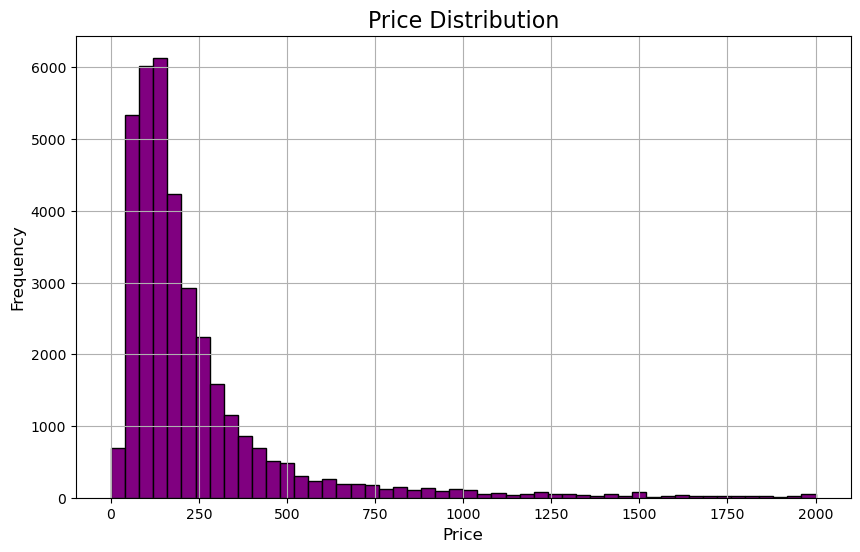

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=50, color='purple', edgecolor='black', range=(0, 2000))
plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

#### Target Vs Features

##### Price Vs Property Characteristics

C:\Users\mdall\AppData\Local\Temp\ipykernel_21492\1828662774.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)


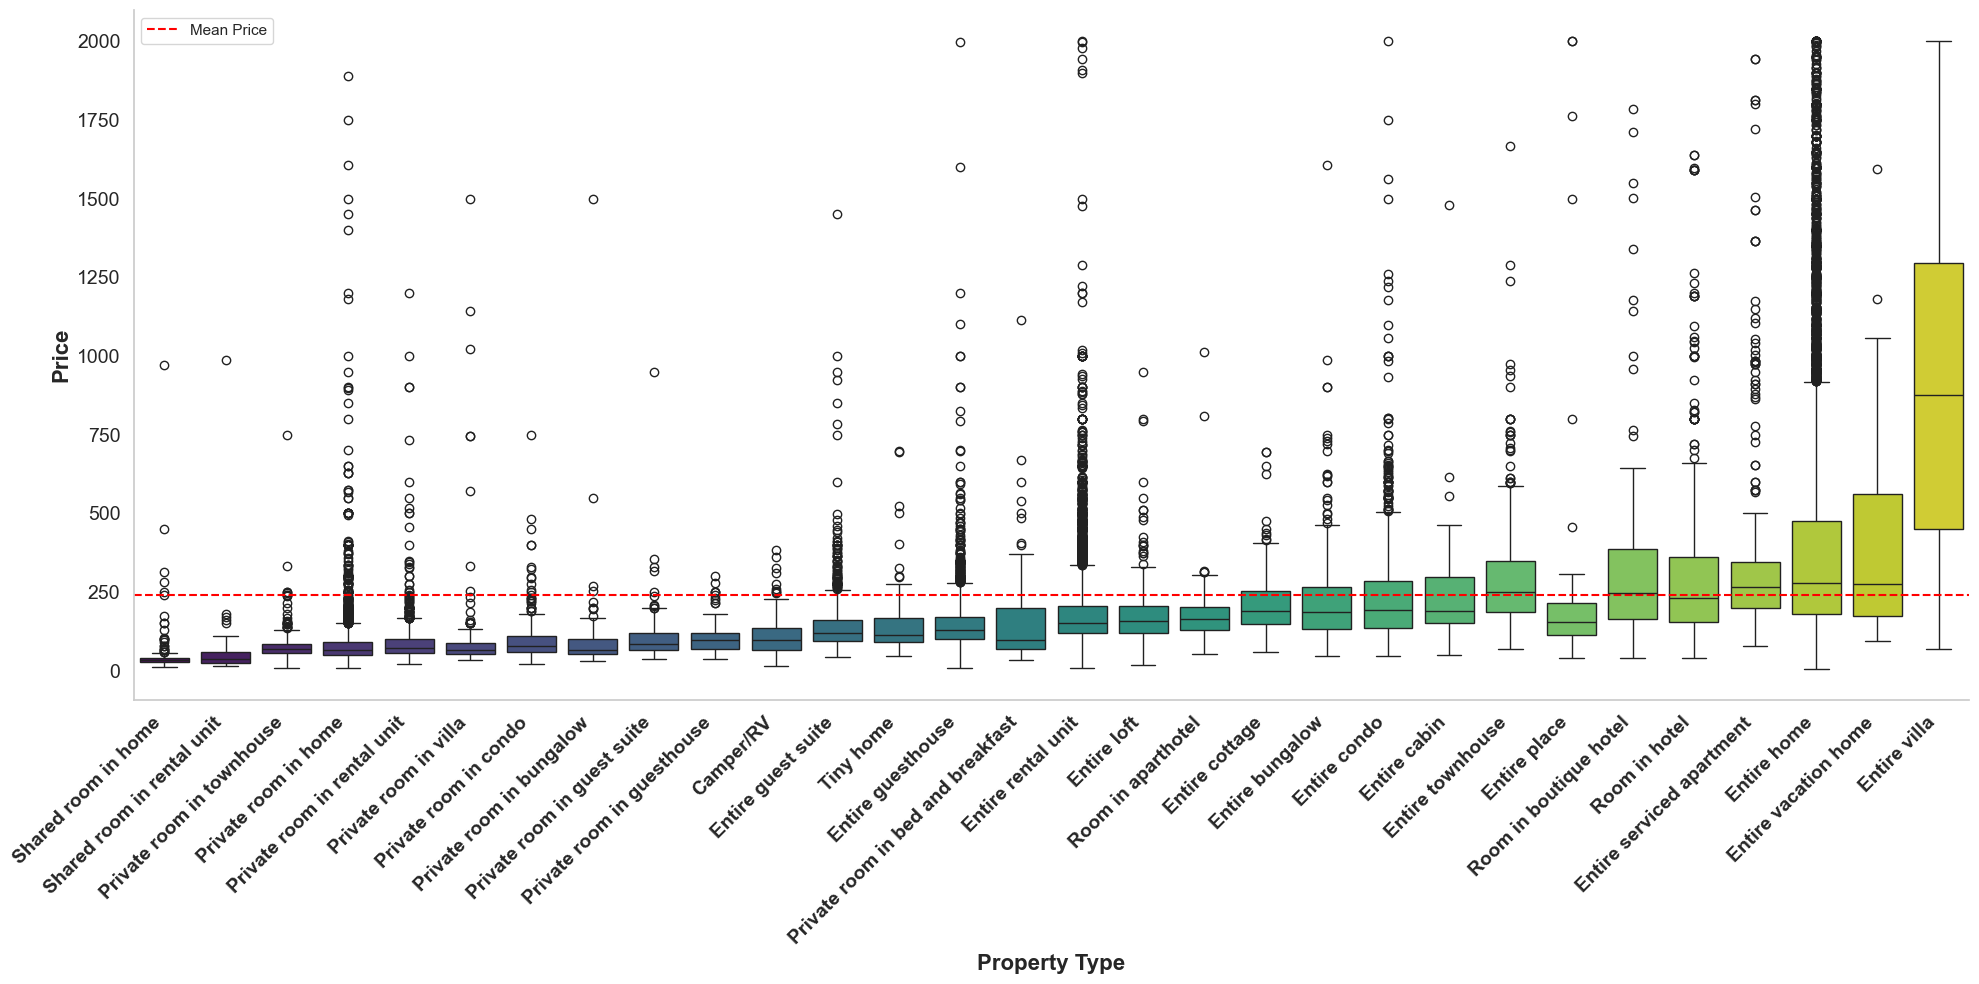

Top 30 Most Common Property Types:
property_type
Entire home                          10513
Entire rental unit                    9325
Private room in home                  4523
Entire guesthouse                     2384
Entire condo                          1458
Private room in rental unit           1209
Entire guest suite                    1110
Entire townhouse                       615
Entire villa                           481
Entire bungalow                        426
Entire serviced apartment              420
Room in hotel                          393
Private room in townhouse              343
Private room in condo                  339
Entire loft                            260
Private room in villa                  220
Shared room in home                    186
Private room in guest suite            169
Room in boutique hotel                 165
Tiny home                              144
Entire cottage                         139
Private room in bed and breakfast      139
Campe

In [18]:

sns.set(style='whitegrid', palette='muted')

# Filter the data for prices between 0 and 2000
filtered_data = data[(data['price'] >= 0) & (data['price'] <= 2000)]

# Get the top 30 most common property types
top_property_types = filtered_data['property_type'].value_counts().nlargest(30).index

# Filter the data to include only the top 30 property types
top_filtered_data = filtered_data[filtered_data['property_type'].isin(top_property_types)]

# Calculate the mean price for each property type in the top 30
mean_prices = top_filtered_data.groupby('property_type')['price'].mean().sort_values()

# Set the size of the figure (increase width for better fitting of labels)
plt.figure(figsize=(20, 10))  # Wider figure for better label visibility

# Create the box plot sorted by mean price
sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)

# Set the title and labels with font size and weight
plt.xlabel('Property Type', fontsize=16, fontweight='bold')
plt.ylabel('Price', fontsize=16, fontweight='bold')

# Remove the outline and grid lines
sns.despine()  # Remove the top and right spines
plt.grid(False)  # Disable the grid

# Adjust x-axis tick labels for better visibility with increased font size
plt.xticks(rotation=45, ha='right', fontsize=14, fontweight='bold')  # Increased font size and bold font
plt.yticks(fontsize=14)

# Add a horizontal line at the mean price
mean_price = top_filtered_data['price'].mean()  # Mean price for the filtered data
plt.axhline(mean_price, color='red', linestyle='--', label='Mean Price')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

# Find the most common property types
most_common_property_types = top_filtered_data['property_type'].value_counts().head(30)
print("Top 30 Most Common Property Types:")
print(most_common_property_types)

##### Price Vs Neighbourhood

In [19]:
# Sample DataFrame for demonstration (replace this with your actual data)
# data = pd.read_csv('your_data_file.csv')

# Create a base map centered around LA with a less prominent background
la_location = [34.0522, -118.2437]  # Coordinates for Los Angeles
m = folium.Map(location=la_location, zoom_start=12, tiles='CartoDB positron')  # Using CartoDB positron for a lighter background

# Prepare the data: Filter out rows where price is NaN
filtered_data = data.dropna(subset=['price'])

# Sample a subset of data for faster processing (e.g., 10% of the data)
sample_size = int(len(filtered_data) * 0.1)
filtered_data_sample = filtered_data.sample(n=sample_size, random_state=42)

# Define a function to get color based on price ranges
def get_color(price):
    if price < 50:
        return 'green'
    elif 50 <= price < 100:
        return 'lime'
    elif 100 <= price < 150:
        return 'yellow'
    elif 150 <= price < 200:
        return 'orange'
    elif 200 <= price < 250:
        return 'red'
    elif 250 <= price < 300:
        return 'darkred'
    else:
        return 'black'  # For prices 300 and above

# Add CircleMarkers for each listing
for index, row in filtered_data_sample.iterrows():
    # Set a fixed radius
    radius = 7  # You can adjust this value as needed
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=radius,
        color=get_color(row['price']),  # Change color based on price ranges
        fill=True,
        fill_color=get_color(row['price']),
        fill_opacity=0.6,
        popup=f'Price: ${row["price"]}'  # Display price on click
    ).add_to(m)

# Define a function to create a legend
def add_legend(map_object):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; 
                width: 200px; height: auto; 
                z-index: 1000; 
                font-size: 14px; 
                background-color: white; 
                padding: 10px; 
                border: 2px solid grey; 
                border-radius: 5px;">
        <h4 style="text-align: center;">Price Range Legend</h4>
        <i style="background: green; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>< $50<br></span>
        <i style="background: lime; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$50 - $100<br></span>
        <i style="background: yellow; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$100 - $150<br></span>
        <i style="background: orange; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$150 - $200<br></span>
        <i style="background: red; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$200 - $250<br></span>
        <i style="background: darkred; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$250 - $300<br></span>
        <i style="background: black; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span> > $300<br></span>
    </div>
    '''
    map_object.get_root().html.add_child(folium.Element(legend_html))

add_legend(m)

m

##### Price Vs Review Sentiment

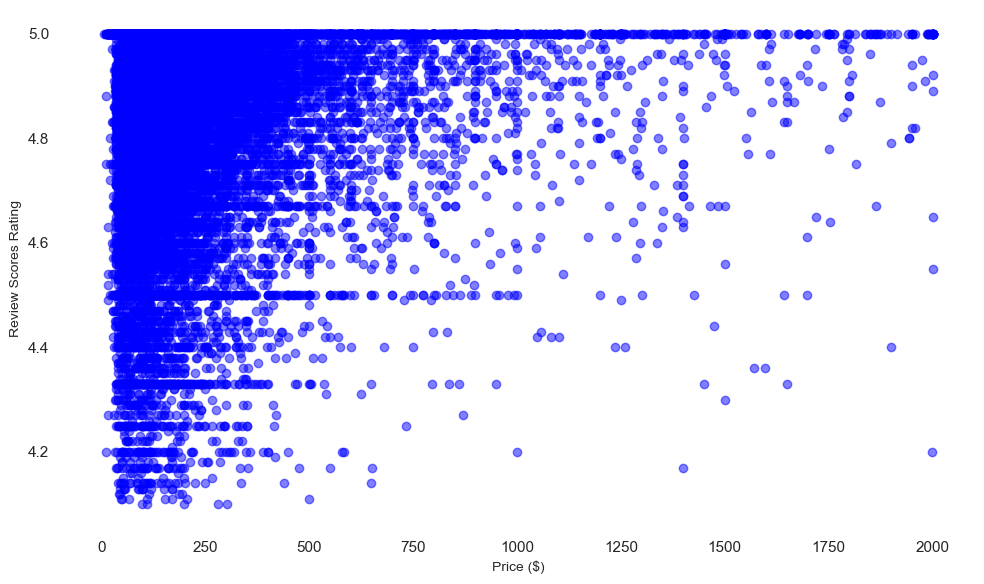

In [20]:
# Filter data for prices between 0 and 2000 and ratings between 4.85 and 5
filtered_data = data[(data['price'] >= 0) & (data['price'] <= 2000) & (data['review_scores_rating'] >= 4.1)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['price'], filtered_data['review_scores_rating'], alpha=0.5, color='blue')

# Set the labels with reduced font size
plt.xlabel('Price ($)', fontsize=10)
plt.ylabel('Review Scores Rating', fontsize=10)

# Remove grid lines, borders, and title for a cleaner look
plt.box(False)  # Remove the border
plt.grid(False)  # Remove grid lines

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\mdall\AppData\Local\Temp\ipykernel_21492\1000813674.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='accommodates', y='price', palette='viridis')


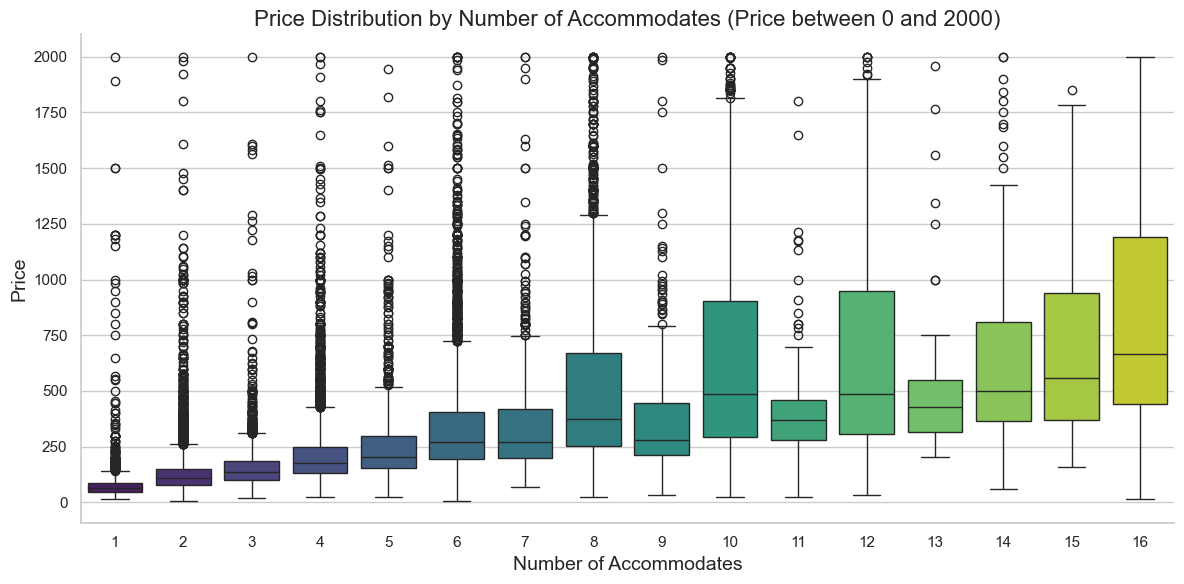

In [21]:
# Filter the data for prices between 0 and 2000
filtered_data = data[(data['price'] >= 0) & (data['price'] <= 2000)]

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Create the box plot
sns.boxplot(data=filtered_data, x='accommodates', y='price', palette='viridis')

# Set the title and labels
plt.title('Price Distribution by Number of Accommodates (Price between 0 and 2000)', fontsize=16)
plt.xlabel('Number of Accommodates', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Remove gridlines and outline
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

#### Qualitative

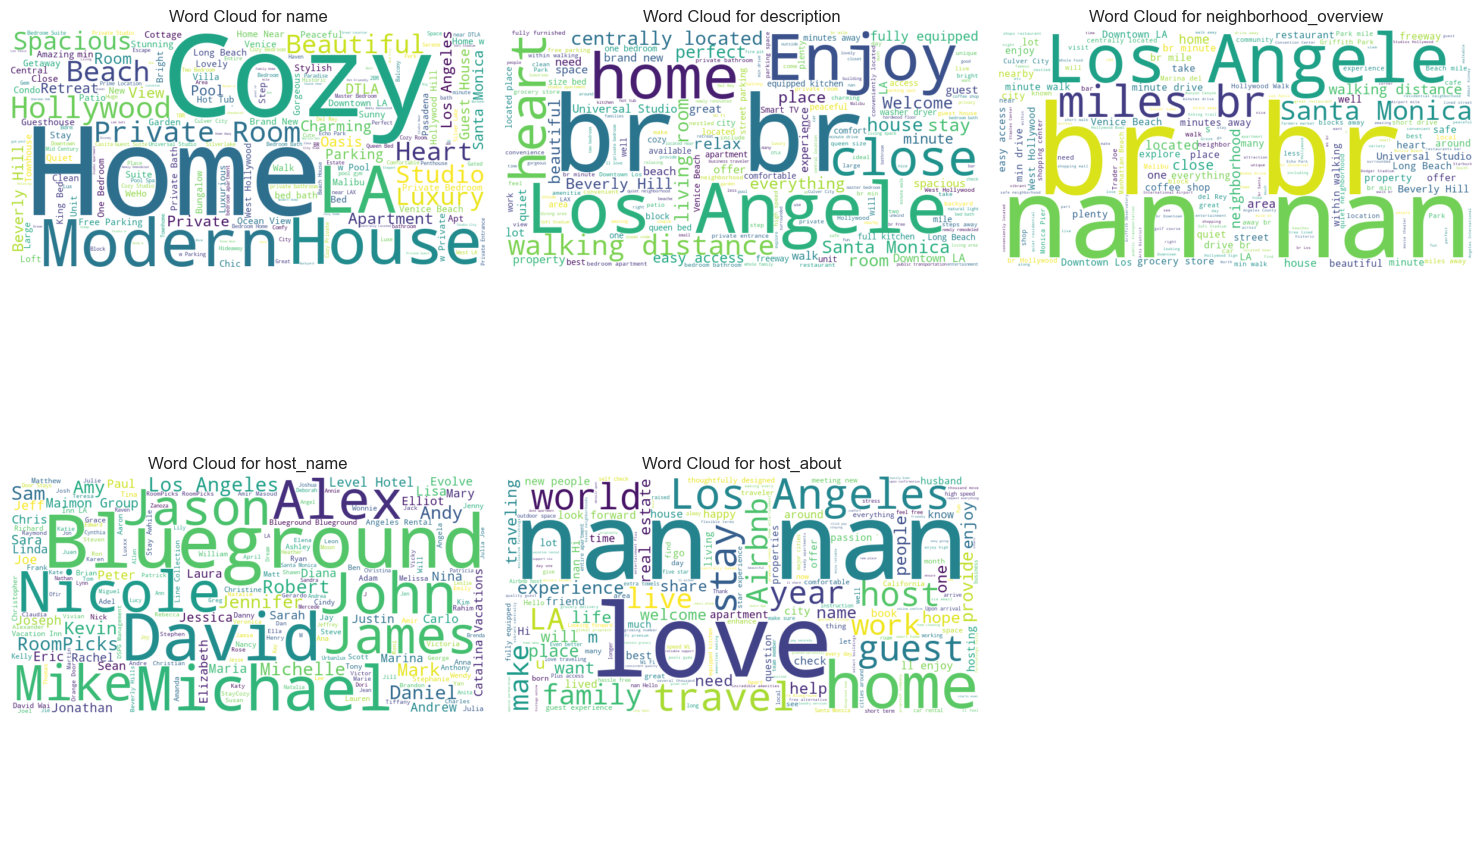

In [22]:
# Create subplots for word clouds
num_features = len(qualitative_features)
num_columns = 3  # Number of plots per row
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate word clouds for each qualitative feature
for i, feature in enumerate(qualitative_features):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[feature].dropna()))
    
    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Word Cloud for {feature}')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

#### Categorical

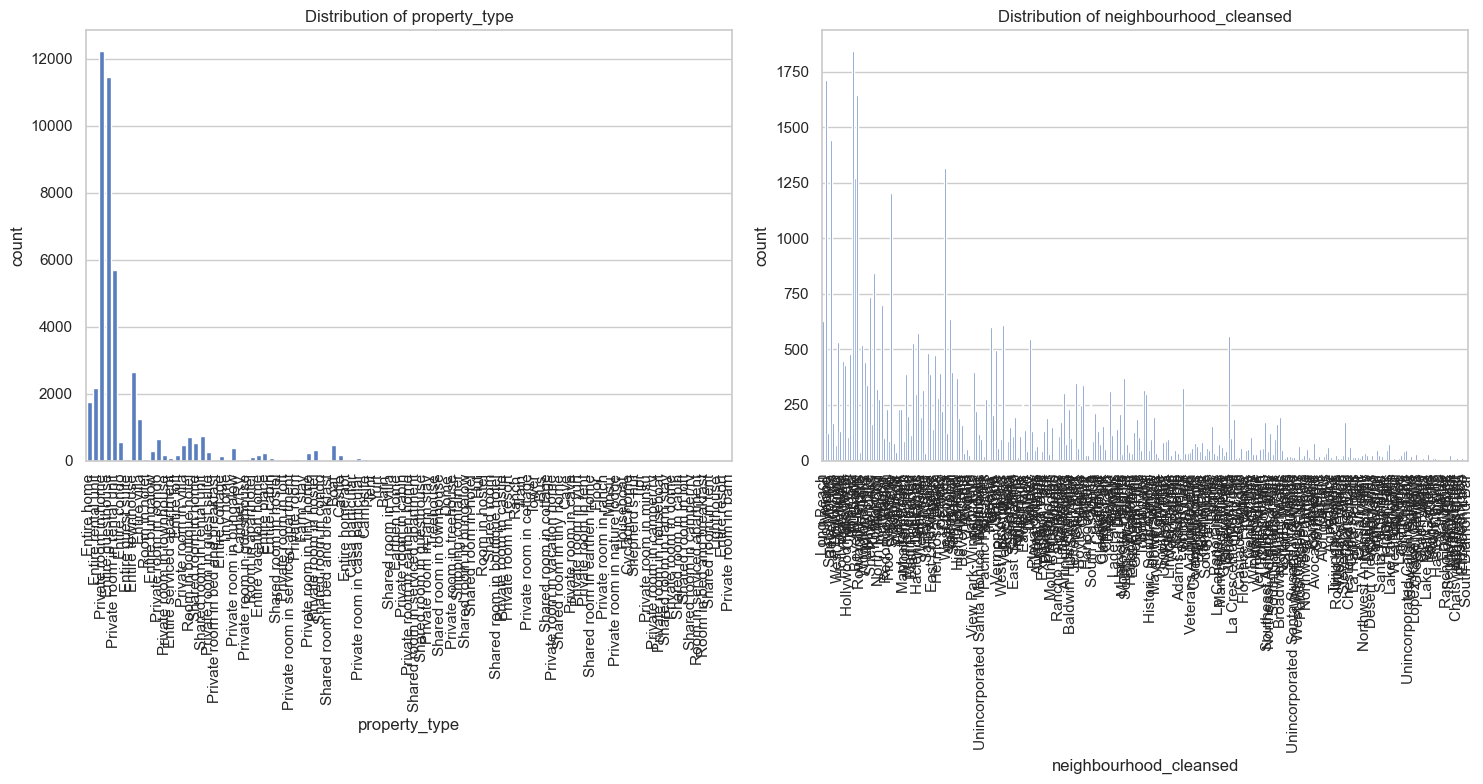

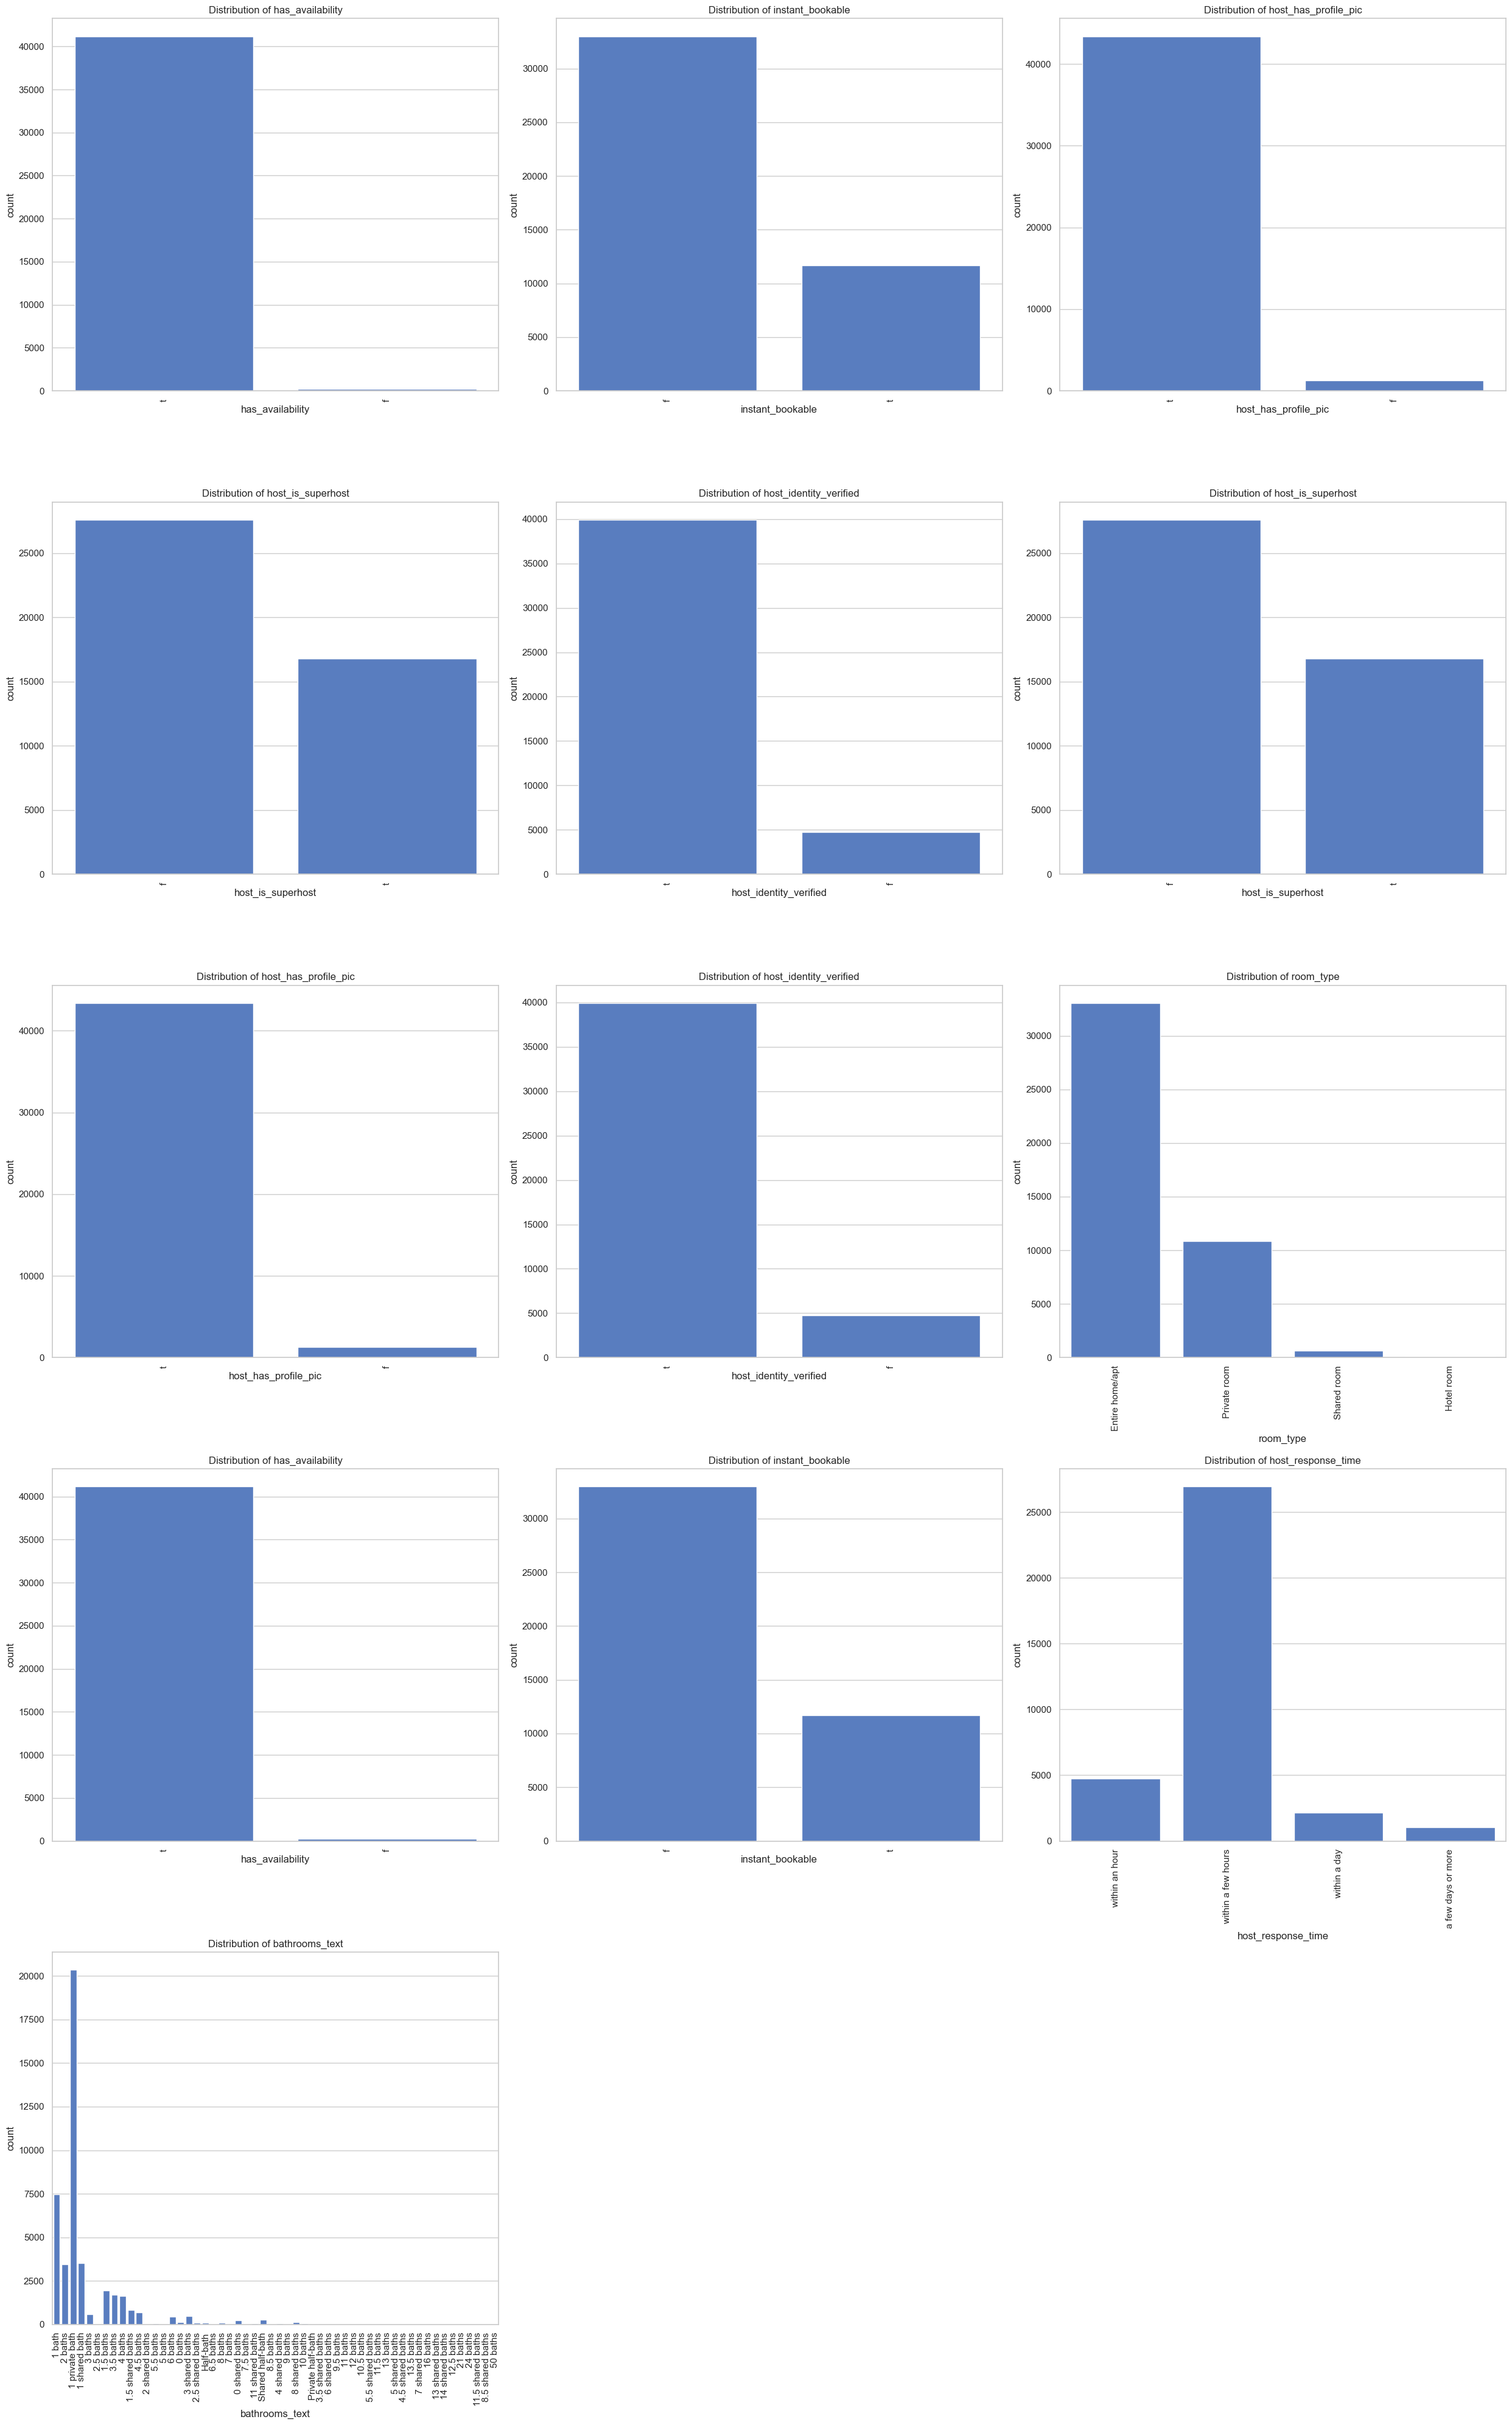

In [23]:
specific_features = ['property_type', 'neighbourhood_cleansed']
other_categorical_features = [feature for feature in binary_categorical_features + multi_categorical_features if feature not in specific_features]

fig, axes = plt.subplots(nrows=1, ncols=len(specific_features), figsize=(15, 8))

for i, feature in enumerate(specific_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xticks(range(len(data[feature].value_counts())))  
    axes[i].set_xticklabels(data[feature].value_counts().index, rotation=90) 

plt.tight_layout()
plt.show()

num_features = len(other_categorical_features)
num_columns = 3 
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 8 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(other_categorical_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xticks(range(len(data[feature].value_counts())))  
    axes[i].set_xticklabels(data[feature].value_counts().index, rotation=90)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### Continous

In [ ]:
all_features = continuous_features + continous_features_minmax
num_features = len(all_features)
num_columns = 3 
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 4 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(all_features):
    if feature in continuous_features:
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
    else:
        sns.countplot(x=data[feature], ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        
        axes[i].set_xticks(axes[i].get_xticks())  
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()